In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Fri Mar  5 11:32:57 PST 2021


In [2]:
# ## TODO

# pull sdi and other missing covariates

# shift, logit transform pct pop eating vehicle
# impute missing vals for logical set of covariates (watch for covariance)
# run a linear regression by vehicle

# use outputs to predict pct pop eating vehicle / pct pop eating ind prod vehicle, shifted and logit transformed

# then finally ind prod / fortified, same method

# --- 

# updates and adjustments can include gradient boosting and throwing in more/all covariates
# clipping as opposed to shifted logit


In [3]:
data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_data_estimated.csv'

# df = pd.read_csv(data_path)
df = pd.read_csv('test_add_gbd_covs.csv')

In [4]:
fao_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/FAOSTAT_food_supply_aggregated_oil_2018.csv'
# fao_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/FAOSTAT_food_supply_2018.csv'
fao = pd.read_csv(fao_path)

In [5]:
fao.loc[(fao.location_name=="Viet Nam"),'location_name'] = "Vietnam"

In [6]:
df = df.merge(fao, on = 'location_name', how = 'left')

In [7]:
df = df.drop(columns=['standard'])

In [8]:
# df = df[df.vehicle=="wheat flour"].drop(columns=['sodium'])

In [9]:
df.columns

Index(['location_name', 'vehicle', 'nutrient',
       'percent of population eating vehicle',
       'percent of population eating industrially produced vehicle',
       'percent of population eating fortified vehicle', 'location_id',
       'sodium', 'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all'],
      dtype='object')

In [10]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

In [11]:
nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

In [12]:
nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

In [13]:
df_numeric = df.copy()
df_numeric['location_name'] = df_numeric.location_name.map(loc_map)
df_numeric['vehicle'] = df_numeric.vehicle.map(vcl_map)
df_numeric['nutrient'] = df_numeric.nutrient.map(nut_map)

In [14]:
df_numeric.head()

,location_name,vehicle,nutrient,percent of population eating vehicle,percent of population eating industrially produced vehicle,percent of population eating fortified vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
0,0,2,3,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
1,0,2,0,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
2,0,2,6,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
3,0,2,1,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
4,0,2,2,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0


In [15]:
df_numeric.groupby('vehicle').count()

,location_name,nutrient,percent of population eating vehicle,percent of population eating industrially produced vehicle,percent of population eating fortified vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
vehicle,,,,,,,,,,,,,,
0,6,6,2,4,5,6,6,6,6,6,6,6,6,6
1,102,102,48,48,48,102,102,102,102,102,96,96,96,96
2,150,150,102,102,105,150,150,150,150,150,138,138,138,138
3,28,28,12,4,16,28,28,28,28,28,24,24,24,24
4,50,50,36,22,35,50,50,50,50,50,46,46,46,46
5,15,15,10,10,10,15,15,15,15,15,15,15,15,15


In [16]:
df_numeric.columns = [i.replace(" ","_") for i in df_numeric.columns]

In [17]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']

In [18]:
for var in estimation_vars:
    print(f'{df_numeric[var].isnull().sum()}/{len(df_numeric)} missing for {var}')

141/351 missing for percent_of_population_eating_vehicle
161/351 missing for percent_of_population_eating_industrially_produced_vehicle
132/351 missing for percent_of_population_eating_fortified_vehicle


In [19]:
## create a version with holdouts
df_partial = df_numeric.copy()
for _ in range(len(df_numeric)*3 // 6):
    j = np.random.choice(estimation_vars)
    i = np.random.choice(df.index[df_partial[j].notnull()])
    df_partial.loc[i,j] = np.nan

In [20]:
for var in estimation_vars:
    print(f'{df_partial[var].isnull().sum()}/{len(df_partial)} missing for {var}')

204/351 missing for percent_of_population_eating_vehicle
220/351 missing for percent_of_population_eating_industrially_produced_vehicle
185/351 missing for percent_of_population_eating_fortified_vehicle


In [21]:
from statsmodels.imputation import mice

In [22]:
imp = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_partial)

In [23]:
%%time
N = 5
df_imputed = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp.update_all(n_iter=100)
    df_imputed[r] = imp.data

. . . . . CPU times: user 3min 7s, sys: 179 ms, total: 3min 7s
Wall time: 3min 7s


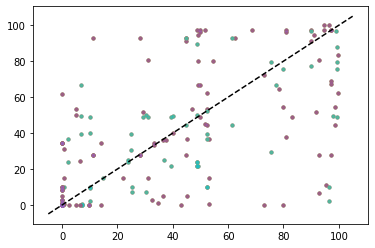

In [24]:
# let's see if we can improve with some covariates?
for col in estimation_vars:
    for df_i in df_imputed.values():
        rows = df_partial[col].isnull() & df_numeric[col].notnull()
        plt.plot(df_numeric.loc[list(rows), col], df_i.loc[list(rows), col], '.', alpha=.5)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.plot([lb, ub], [lb, ub], 'k--')

# what happens when we use all data?

In [29]:
imp_full = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_numeric)

In [30]:
%%time
N = 5
df_imputed_full = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp_full.update_all(n_iter=100)
    df_imputed_full[r] = imp.data

. . . . . CPU times: user 1min 14s, sys: 60.5 ms, total: 1min 14s
Wall time: 1min 14s


In [31]:
# checkout performance

In [32]:
# does imp remember prev iters? should df_imputed[i+1] be 'better' than df_imputed[i]?
# did they all do the same?

In [33]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_vehicle <
                  df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle)].shape[0])

94
94
94
94
94


In [34]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle <
                  df_imputed_full[i].percent_of_population_eating_fortified_vehicle)].shape[0])

32
32
32
32
32
